<a href="https://www.kaggle.com/code/vialomurvialomur/xray-pneumonia?scriptVersionId=142466839" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
print(tf.__version__)

2.12.0


In [3]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
validation_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

train_normal_dir = os.path.join(train_dir, 'NORMAL')

train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

validation_normal_dir = os.path.join(validation_dir, 'NORMAL')

validation_pneumonia_dir = os.path.join(validation_dir, 'PNEUMONIA')


print(f"There are {len(os.listdir(train_normal_dir))} images of normal chest for training.\n")
print(f"There are {len(os.listdir(train_pneumonia_dir))} images of pneumonia chest for training.\n")
print(f"There are {len(os.listdir(validation_normal_dir))} images of normal chest for validation.\n")
print(f"There are {len(os.listdir(validation_pneumonia_dir))} images of pneumonia chest for validation.\n")

There are 1341 images of normal chest for training.

There are 3875 images of pneumonia chest for training.

There are 8 images of normal chest for validation.

There are 8 images of pneumonia chest for validation.



Sample normal chest image:


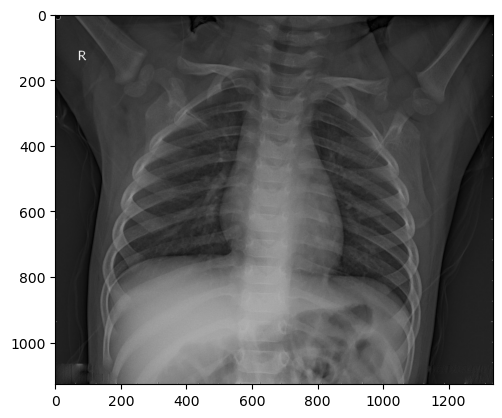


Sample pneumonia chest image:


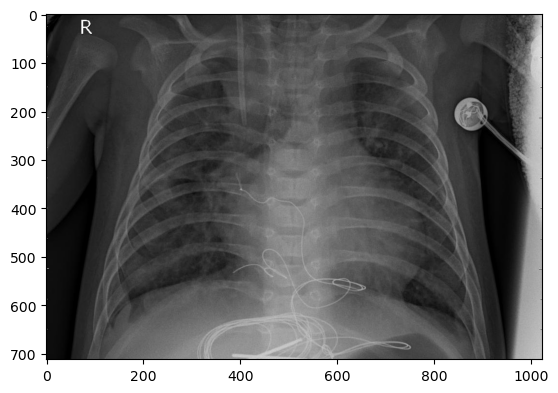

In [4]:
print("Sample normal chest image:")
plt.imshow(load_img(f"{os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])}"))
plt.show()

print("\nSample pneumonia chest image:")
plt.imshow(load_img(f"{os.path.join(train_pneumonia_dir, os.listdir(train_pneumonia_dir)[0])}"))
plt.show()

In [5]:
import cv2

input_shape = (300, 300, 1)  # Changed the input_shape to include only one channel for grayscale

def rgb_to_grayscale(image):
    # Convert RGB image to grayscale using vectorized operations
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.expand_dims(gray, 2)
    #print(gray.shape)
    return gray

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator(
        rescale=1./255.,
        preprocessing_function=rgb_to_grayscale,  # Add the grayscale conversion function
    )

    train_generator = train_datagen.flow_from_directory(
        directory=TRAINING_DIR,
        batch_size=24,
        class_mode='binary',
        target_size=(input_shape[0], input_shape[1])
    )

    validation_datagen = ImageDataGenerator(
        rescale=1./255.,
        preprocessing_function=rgb_to_grayscale,  # Add the grayscale conversion function
    )

    validation_generator = validation_datagen.flow_from_directory(
        directory=VALIDATION_DIR,
        batch_size=24,
        class_mode='binary',
        target_size=(input_shape[0], input_shape[1])
    )

    return train_generator, validation_generator

In [6]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [7]:
def create_model(input_shape):

    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(24, (3,3), activation='relu', input_shape=input_shape),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    
    return model

In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        #print(logs)
        if(logs.get("val_accuracy")>=0.99):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

In [9]:
callback = myCallback()
model = create_model(input_shape)

with tf.device('/device:GPU:0'):
    history = model.fit(train_generator,
                        epochs=5,
                        verbose=1,
                        validation_data=validation_generator,
                        callbacks=callback)

Epoch 1/5
218/218 [==============================] - ETA: 0s - loss: 0.9924 - accuracy: 0.8995
Reached 99% accuracy so cancelling training!
218/218 [==============================] - 98s 410ms/step - loss: 0.9924 - accuracy: 0.8995 - val_loss: 0.1276 - val_accuracy: 1.0000


In [10]:
from PIL import Image
from numpy import asarray

path_normal = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL'
path_pneumonia = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'
    

In [11]:
def test_prediction(path,amount = 5):
    counter = 0
    input_images = []
    for filename in os.listdir(path):
        if counter >= amount:
            break
            
        f = os.path.join(path, filename)
        image = cv2.imread(f)
        image = cv2.resize(image,(input_shape[0],input_shape[0]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, 2)
        input_images.append(image)
        
        #plt.imshow(image)
        #plt.show()
        counter += 1
        
    predictions = model.predict(np.array(input_images))
    zero_counter = np.count_nonzero(predictions < 0.5)
    one_counter = np.count_nonzero(predictions >= 0.5)
    print(predictions[:5],f"0: {zero_counter} 1:{one_counter}")   
    
test_prediction(path_normal,amount=100)
test_prediction(path_pneumonia,amount=100)

4/4 [==============================] - 0s 23ms/step
[[1.000000e+00]
 [9.176245e-29]
 [0.000000e+00]
 [1.000000e+00]
 [0.000000e+00]] 0: 82 1:18
4/4 [==============================] - 0s 6ms/step
[[1.]
 [1.]
 [0.]
 [1.]
 [1.]] 0: 8 1:92
